In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm import compute_fixed_effects
from nilearn.glm.second_level import SecondLevelModel
import subprocess
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns
from glm_utils import (est_contrast_vifs, generate_tablecontents, create_design_matrix, compute_save_contrasts, plot_design_vifs)
from prep_eventsdata import comb_names, prep_gamble_events, prep_motor_events, prep_social_events, prep_language_events, prep_relation_events, prep_emotion_events, prep_wm_events

In [2]:
generate_tablecontents("pilot_bold-models.ipynb")

# Table of Contents

- [1. Misc Data-pull in Next-steps](#Misc-Data-pull-in-Next-steps)
- [2. Motor Task](#Motor-Task)
  - [2.1. Event Design Matrix](#Event-Design-Matrix)
    - [2.1.1. HCP Model](#HCP-Model)
      - [2.1.1.1. First Level GLM](#First-Level-GLM)
    - [2.1.2. Alt Model](#Alt-Model)
      - [2.1.2.1. First Level GLM](#First-Level-GLM)
- [3. Gamble](#Gamble)
  - [3.1. Events Design Matrix](#Events-Design-Matrix)
    - [3.1.1. HCP Model](#HCP-Model)
      - [3.1.1.1. First Level GLM](#First-Level-GLM)
    - [3.1.2. Alt Model](#Alt-Model)
      - [3.1.2.1. First Level GLM](#First-Level-GLM)
- [4. Social](#Social)
  - [4.1. Event Design Matrix](#Event-Design-Matrix)
    - [4.1.1. HCP Model](#HCP-Model)
      - [4.1.1.1. First Level GLM](#First-Level-GLM)
    - [4.1.2. Alt Model](#Alt-Model)
      - [4.1.2.1. First Level GLM](#First-Level-GLM)
- [5. Language](#Language)
  - [5.1. Event Design Matrix](#Event-Design-Matrix)
    - [5.1.1. HCP Model](#HCP-Model)
      - [5.1.1.1. First Level GLM](#First-Level-GLM)
    - [5.1.2. Alt Model](#Alt-Model)
      - [5.1.2.1. First Level GLM](#First-Level-GLM)
- [6. Relational](#Relational)
  - [6.1. Event Design Matrix](#Event-Design-Matrix)
    - [6.1.1. HCP Model](#HCP-Model)
      - [6.1.1.1. First Level GLM](#First-Level-GLM)
    - [6.1.2. Alt Model](#Alt-Model)
      - [6.1.2.1. First Level GLM](#First-Level-GLM)
- [7. Emotion](#Emotion)
  - [7.1. Events Design Matrix](#Events-Design-Matrix)
    - [7.1.1. HCP Model](#HCP-Model)
      - [7.1.1.1. First Level GLM](#First-Level-GLM)
    - [7.1.2. Alt Model](#Alt-Model)
      - [7.1.2.1. First Level GLM](#First-Level-GLM)
- [8. Working Memory](#Working-Memory)
  - [8.1. Event Design Matrix](#Event-Design-Matrix)
    - [8.1.1. HCP Model](#HCP-Model)
      - [8.1.1.1. First Level GLM](#First-Level-GLM)
    - [8.1.2. Alt Model](#Alt-Model)
      - [8.1.2.1. First Level GLM](#First-Level-GLM)

# Misc Data-pull in Next-steps

In [3]:
subj_id = "837964"
analysis_out = "/scratch.global/mdemiden/hcp_analysis_out"
test_fmriprep_path = "/scratch.global/mdemiden/hcp_bold_test"
schematic_path = "/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskevents"
events_path = "/home/feczk001/mdemiden/data/hcp_events"
studydetails_path = "/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskbold/input_taskmodel.json"
with open(studydetails_path, 'r') as file:
    study_details = json.load(file)

brain_mni_mask = "/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskbold/masks/MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz"

In [4]:
#os.listdir(test_fmriprep_path)

In [5]:
#s3_fmriprep_sublist = ["s3cmd", "ls", "s3://hcp-youth/derivatives/fmriprep_v24_0_1/ses-3T/", "--exclude", "*.html", "--exclude", "*sourcedata"]
#sub_list = subprocess.run(s3_fmriprep_sublist, capture_output=True, text=True)
#lines = sub_list.stdout.splitlines()
#subjects = [line.split()[-1] for line in lines if line] 

In [6]:
#down_to_path = "/tmp/"
#input_s3path = "s3://hcp-youth/derivatives/fmriprep_v24_0_1/ses-3T"
## Construct the S3 sync command
#s3_download_fmriprepderiv = [
#    "s3cmd", "sync", "--recursive",
#    f"{input_s3path}/sub-{subj_id}", down_to_path,
#    "--exclude", "*.h5",
#    "--exclude", "*xfm.json",
#    "--exclude", "*boldref*",
#    "--exclude", "*.gii",
#    "--exclude", "*91k*",
#    "--exclude", "*_T2w.nii.gz",
#    "--exclude", "*_T21w.nii.gz",
#    "--exclude", "*dseg.nii.gz"
#]
#sync_result = subprocess.run(s3_download_fmriprepderiv, capture_output=True, text=True)

# Motor Task

Barch et al. (2013, pg 181). "Five predictors were included in the **Motor model** — right hand, left hand, right foot, left foot, and tongue. Each predictor covered the duration of 10 movement trials (12 s). The 3 s cue period prior to each motor block was modeled separately to account for visual activation related to the cue word presented on the screen at the beginning of each block. Linear contrasts were computed to estimate activation for each movement type versus baseline and versus all other movement types."

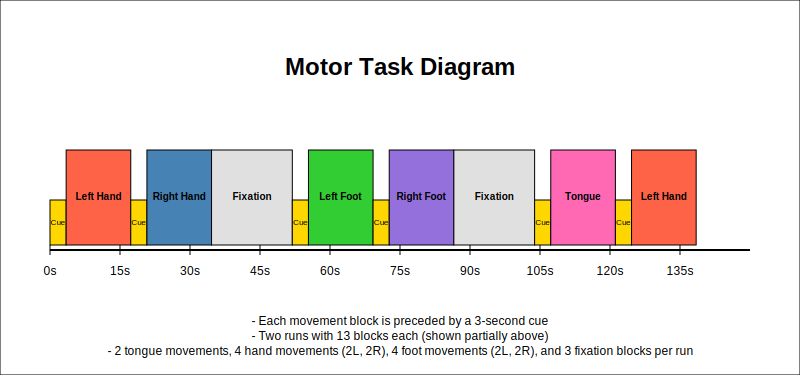

In [7]:
task = "motor"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [8]:
config = study_details[task]
ses="ses-3T"
numvols = 284
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')

### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


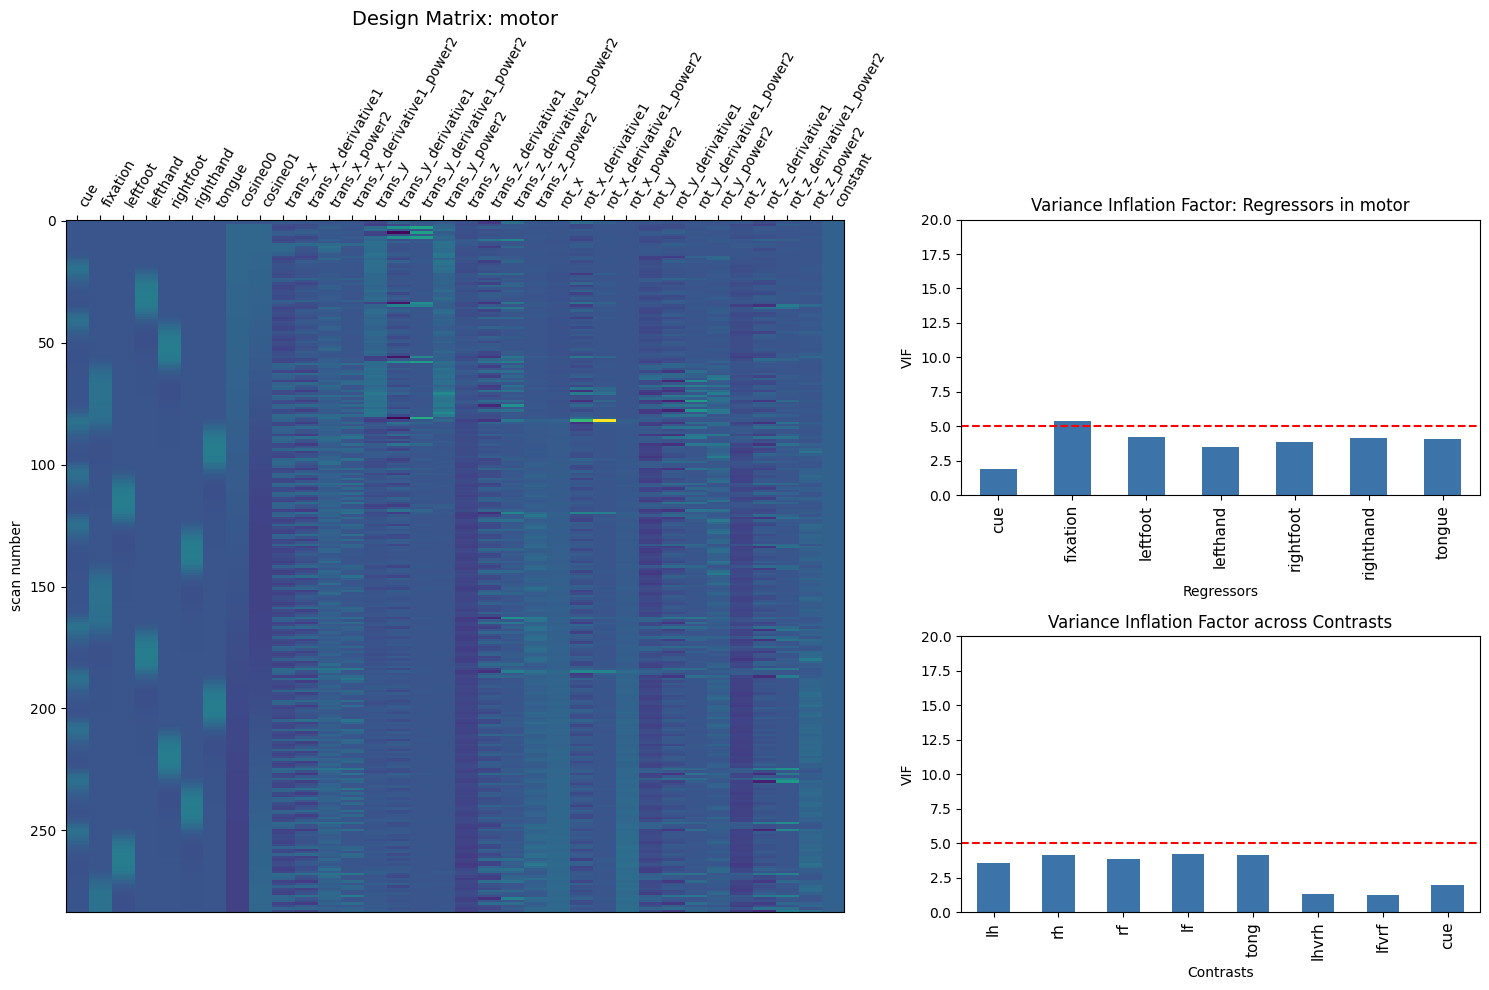

In [9]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_motor_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], incl_trialtypes=mod_config['trialtype_filter'],
                 modtype=mod_spec)
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [10]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast lh with weight lefthand
        Successfully saved contrast lh
    Working on contrast rh with weight righthand
        Successfully saved contrast rh
    Working on contrast rf with weight rightfoot
        Successfully saved contrast rf
    Working on contrast lf with weight leftfoot
        Successfully saved contrast lf
    Working on contrast tong with weight tongue
        Successfully saved contrast tong
    Working on contrast lhvrh with weight lefthand - righthand
        Successfully saved contrast lhvrh
    Working on contrast lfvrf with weight leftfoot - rightfoot
        Successfully saved contrast lfvrf
    Working on contrast cue with weight cue
        Successfully saved contrast cue


### Alt Model

This alternative model introduces a simple modification to the HCP modeling approach. In HCP, the Cue regressor serves as a single regressor for each block, irrespective of the condition type. However, as illustrated [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_motor), the duration of Cue is, on average, 2970 ms. Given this length, it is likely that motor-relevant preparatory signals contribute to the response. Therefore, instead of using a generic cue signal, the regressors should account for the cognitively relevant signal specific to each block. To achieve this, the model is expanded to include separate regressors for each movement condition, along with a cue regressor for each condition.

**Expected Difference in Activation between HCP and Alt Model**: Minor

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


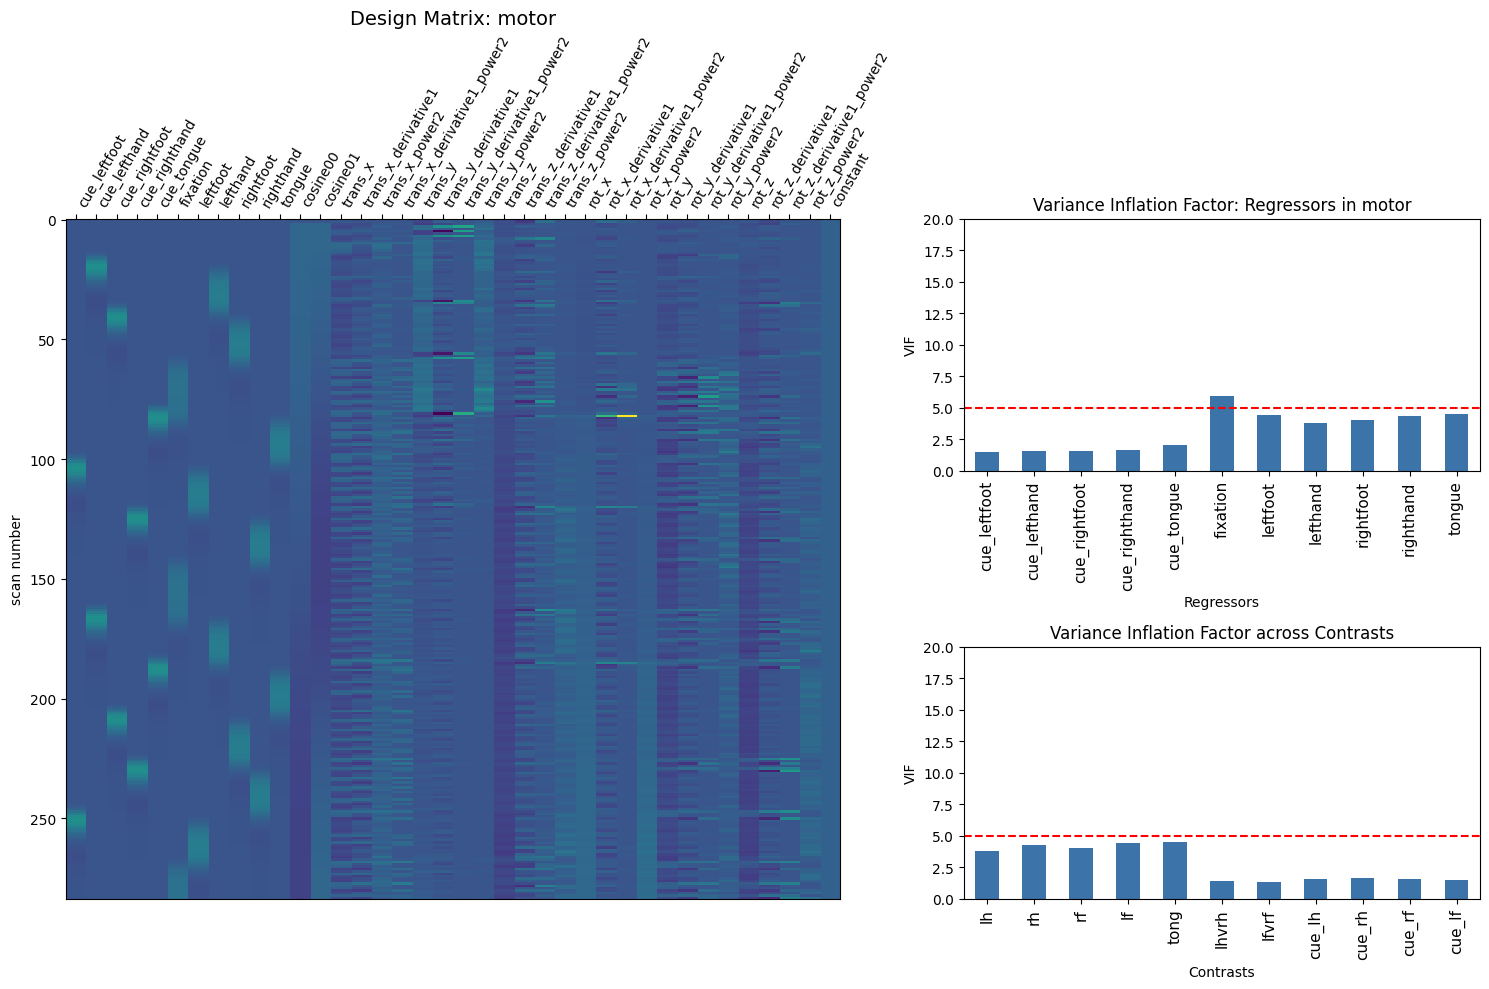

In [11]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_motor_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                               incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec)
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [12]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast lh with weight lefthand
        Successfully saved contrast lh
    Working on contrast rh with weight righthand
        Successfully saved contrast rh
    Working on contrast rf with weight rightfoot
        Successfully saved contrast rf
    Working on contrast lf with weight leftfoot
        Successfully saved contrast lf
    Working on contrast tong with weight tongue
        Successfully saved contrast tong
    Working on contrast lhvrh with weight lefthand - righthand
        Successfully saved contrast lhvrh
    Working on contrast lfvrf with weight leftfoot - rightfoot
        Successfully saved contrast lfvrf
    Working on contrast cue_lh with weight cue_lefthand
        Successfully saved contrast cue_lh
    Working on contrast cue_rh with weight cue_righthand
        Successfully saved contrast cue_rh
    Working on contrast cue_rf with weight cue_rightfoot
        Successfully saved contrast cue_rf
    Working on contrast cue_lf with weight cue_leftf

# Gamble

Barch et al. (2013, pg 181). "Two predictors were included in the model for **Incentive Processing** — mostly reward and mostly loss blocks, each covering the duration of 8 trials (28 s). For this task, as with all other tasks, linear contrasts of the parameter estimates were computed to compare each condition to baseline and to each other."

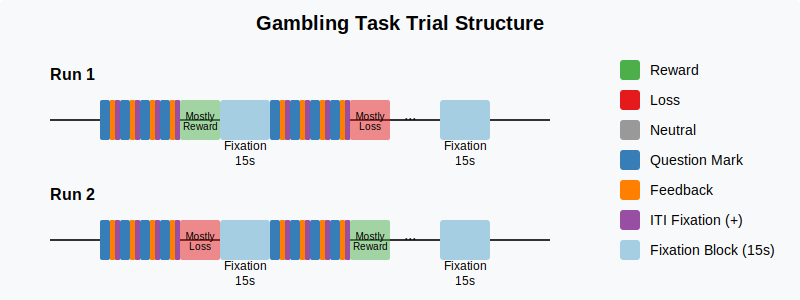

In [13]:
task = "gambling"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Events Design Matrix

In [14]:
config = study_details[task]
ses='ses-3T'
numvols = 253
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['quest_mark', 'full_gamble', 'filler', 'feedback', 'isi_1sec',
       'fixation'], dtype=object)

### HCP Model

Dropping 1 rows with None/NaN in 'onsets' column.
    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


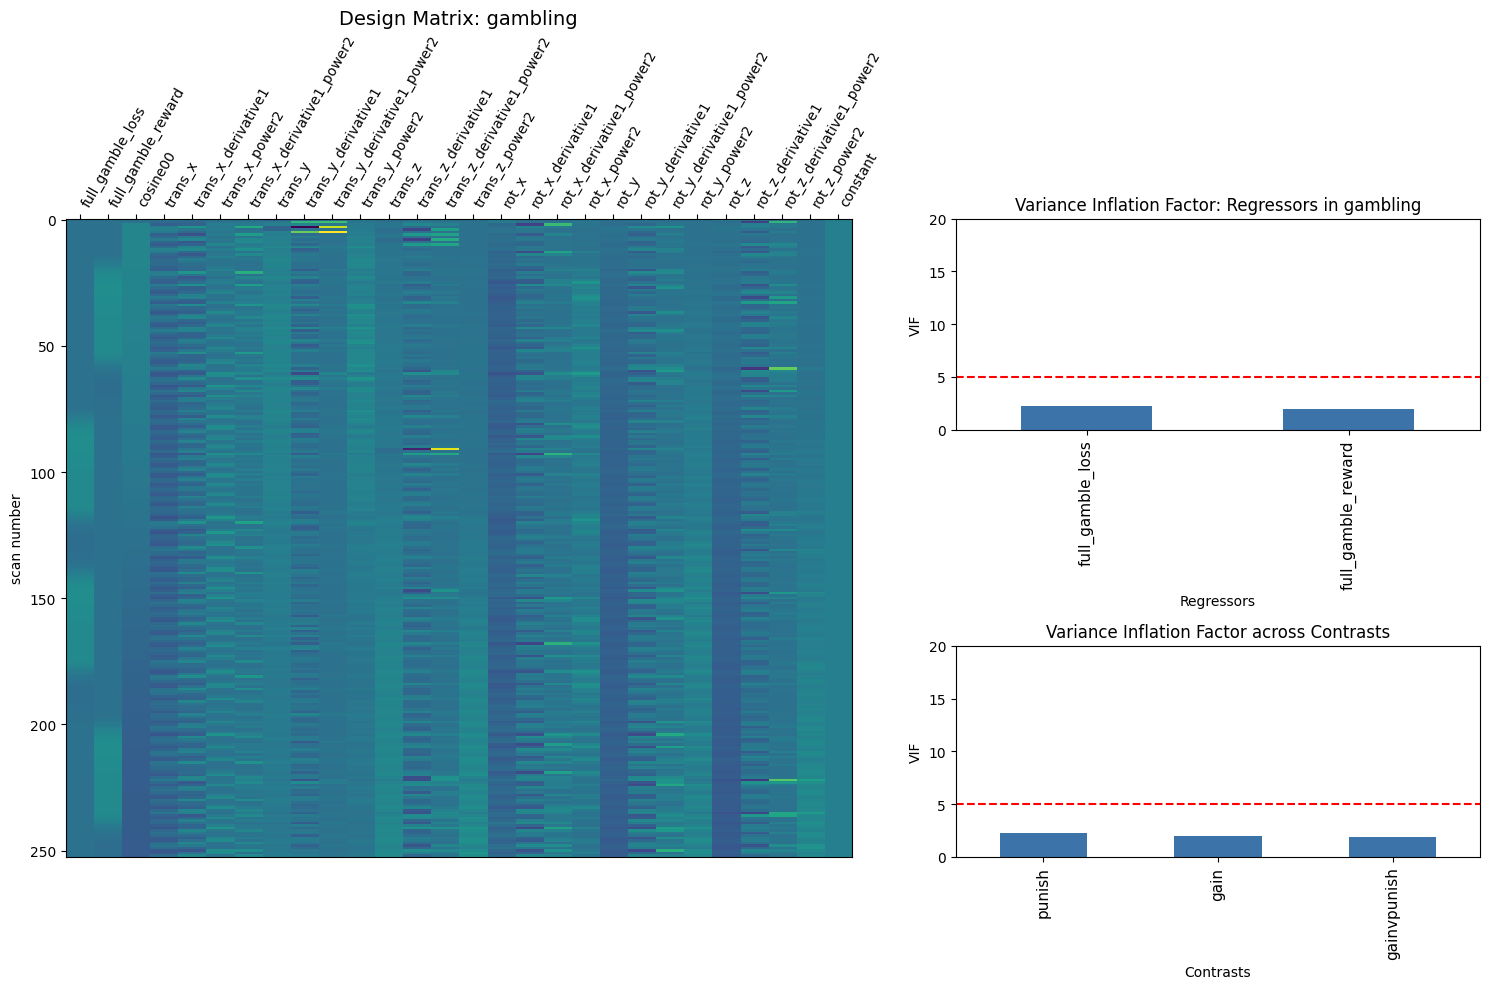

In [15]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_gamble_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [16]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast punish with weight full_gamble_loss
        Successfully saved contrast punish
    Working on contrast gain with weight full_gamble_reward
        Successfully saved contrast gain
    Working on contrast gainvpunish with weight full_gamble_reward - full_gamble_loss
        Successfully saved contrast gainvpunish


### Alt Model

In the HCP model, entire blocks are categorized as either "mostly reward" or "mostly punishment." This approach compresses all within-trial variability—such as differences in selecting above or below and variations in responses to feedback—into a single parameter. Consequently, the resulting construct is noisy, difficult to interpret, and highly variable. For example, the difference between "mostly reward" and "mostly punishment" conditions can be as little as one or two trials. As a result, reward- and punishment-related effects are attenuated.

For a visualization of the timing distribution, see the figures [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_gambling).

An alternative approach is to model the decision phase (question mark) and the outcome phase (feedback) separately. This has two key advantages:

1. It distinguishes the cognitive processes involved in decision-making from those involved in outcome evaluation.
2. It allows for within-trial estimates of BOLD fluctuations related to decision-making (higher vs. lower choices) and feedback type (Neutral, Gain, or Loss).

However, this approach has limitations. First, the events are rapid—on average, participants make a decision within 550 ms. Second, the decision and feedback phases are temporally close, sometimes separated by only an 850 ms filler and variable presentation. Specifically, if participants fail to respond or exceed the threshold (~1500ms), no filler is presented (i.e., a fixation cross screen). Response times (RTs) also differ across conditions, particularly in reward trials within mostly punishment blocks, where RTs are, on average, nearly 200 ms slower. The feedback duration and interstimulus intervals remain relatively constant at 990–1020 ms and 1000–1070 ms, respectively.

In modeling these independent components, accounting for RT in trial-by-trial models might seem important. However, the duration of the decision phase (question mark) is contingent on RT. This introduces collinearity into the design, meaning that including an RT regressor would result in an exceedingly high variance inflation factor (VIF), making estimation unreliable. In a way, the question mark regressor would account for the trial-by-trial RT variability.


**Expected Difference in Activation between HCP and Alt Model**: Substantial

Dropping 1 rows with None/NaN in 'onsets' column.
    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


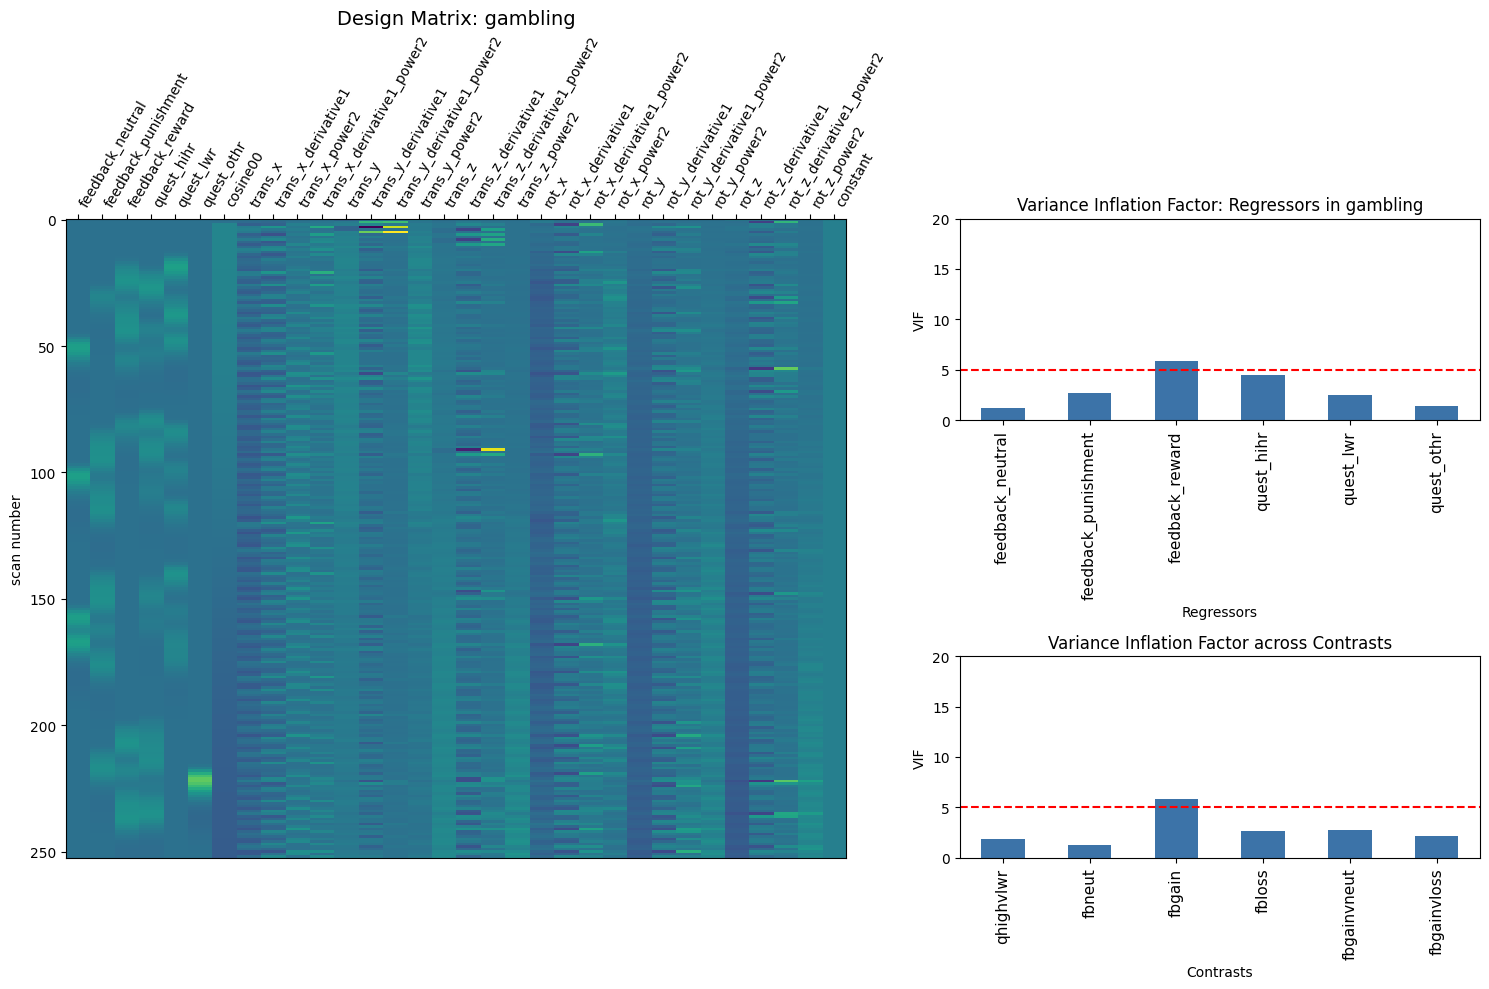

In [17]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_gamble_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [18]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast qhighvlwr with weight quest_hihr - quest_lwr
        Successfully saved contrast qhighvlwr
    Working on contrast fbneut with weight feedback_neutral
        Successfully saved contrast fbneut
    Working on contrast fbgain with weight feedback_reward
        Successfully saved contrast fbgain
    Working on contrast fbloss with weight feedback_punishment
        Successfully saved contrast fbloss
    Working on contrast fbgainvneut with weight feedback_reward - feedback_neutral
        Successfully saved contrast fbgainvneut
    Working on contrast fbgainvloss with weight feedback_reward - feedback_punishment
        Successfully saved contrast fbgainvloss


# Social 

Barch et al. (2013, pg 181). "Two predictors were included in the Social Cognition model — Social and Random motion. Predictors were based on the category of the video clip rather than the rating of the individual. Each predictor covered the duration of a single video clip (20 s)."

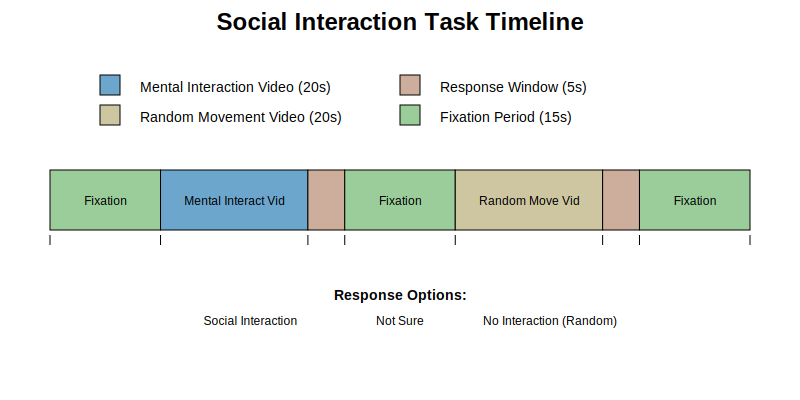

In [19]:
task = "social"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix 

In [20]:
config = study_details[task]
ses='ses-3T'
numvols = 274
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['movie', 'social_full', 'response', 'fixation'], dtype=object)

The HCP only modeled the Movie durations for Social and Random categories. So no response windows are modeled and considered in their subject-level models. Based on the timing distributions, which you can find [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_social), there are minor differences in response times (RT) between the random and mental interaction conditions. With 'not sure', often having a slowest response times. However, it may be of interest to account for the response time window and the RT times.

**Expected Difference in Activation between HCP and Alt Model**: Movie-relevant, Minimal; Response-relevant, high.

### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


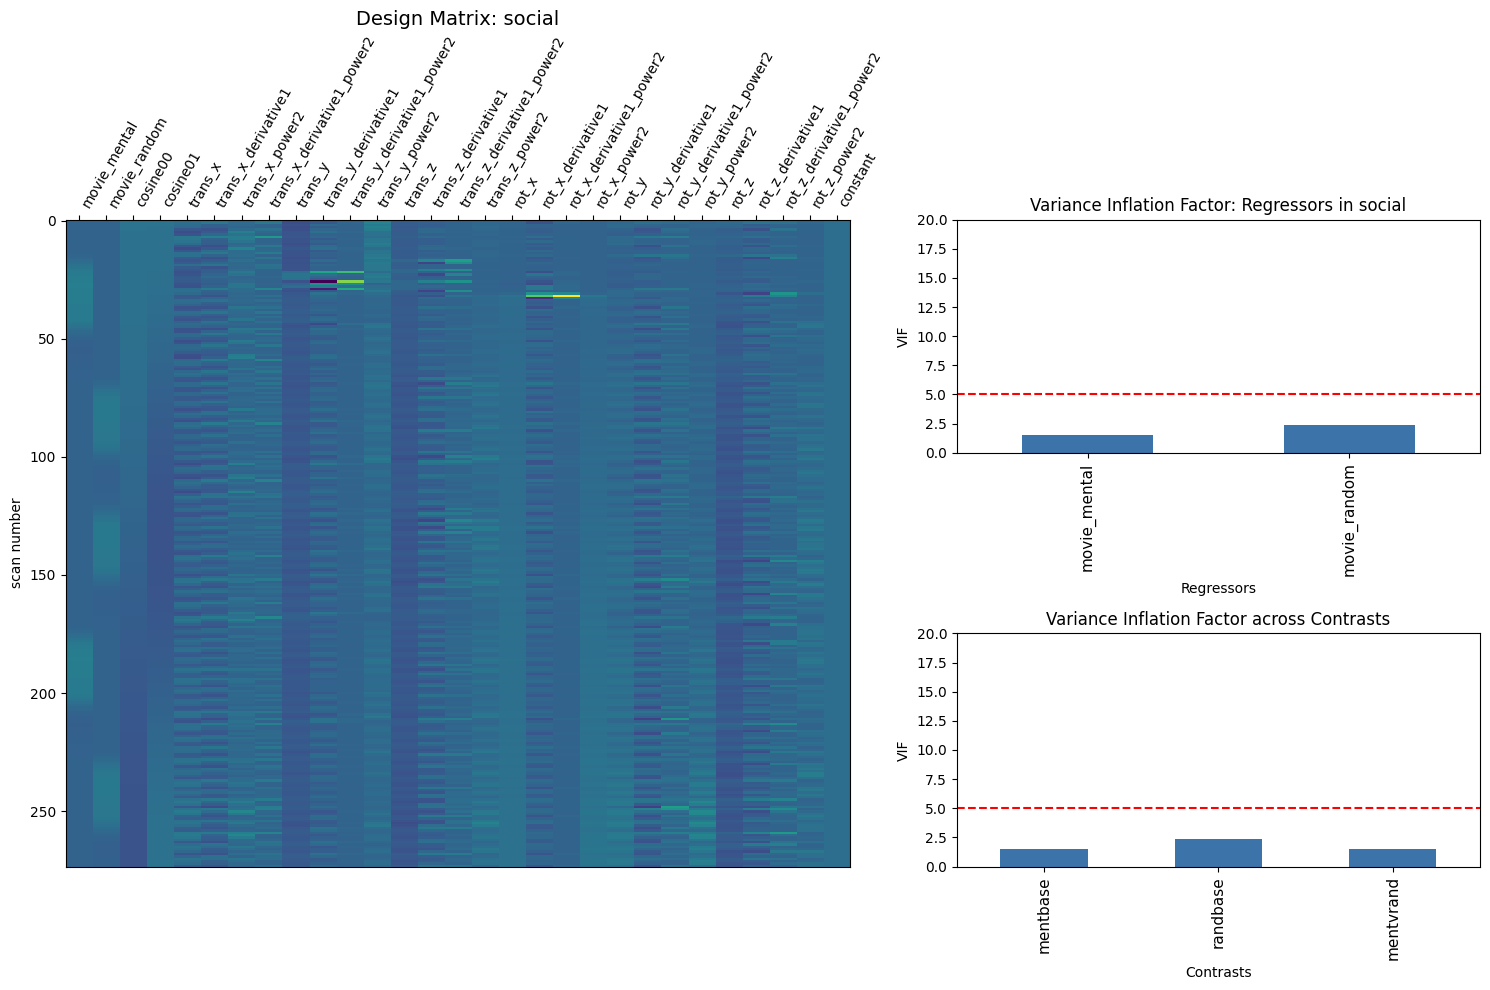

In [21]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_social_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [22]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast mentbase with weight movie_mental
        Successfully saved contrast mentbase
    Working on contrast randbase with weight movie_random
        Successfully saved contrast randbase
    Working on contrast mentvrand with weight movie_mental - movie_random
        Successfully saved contrast mentvrand


### Alt Model

/panfs/jay/groups/2/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/.venv/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
rt.
  warnings.warn(


    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


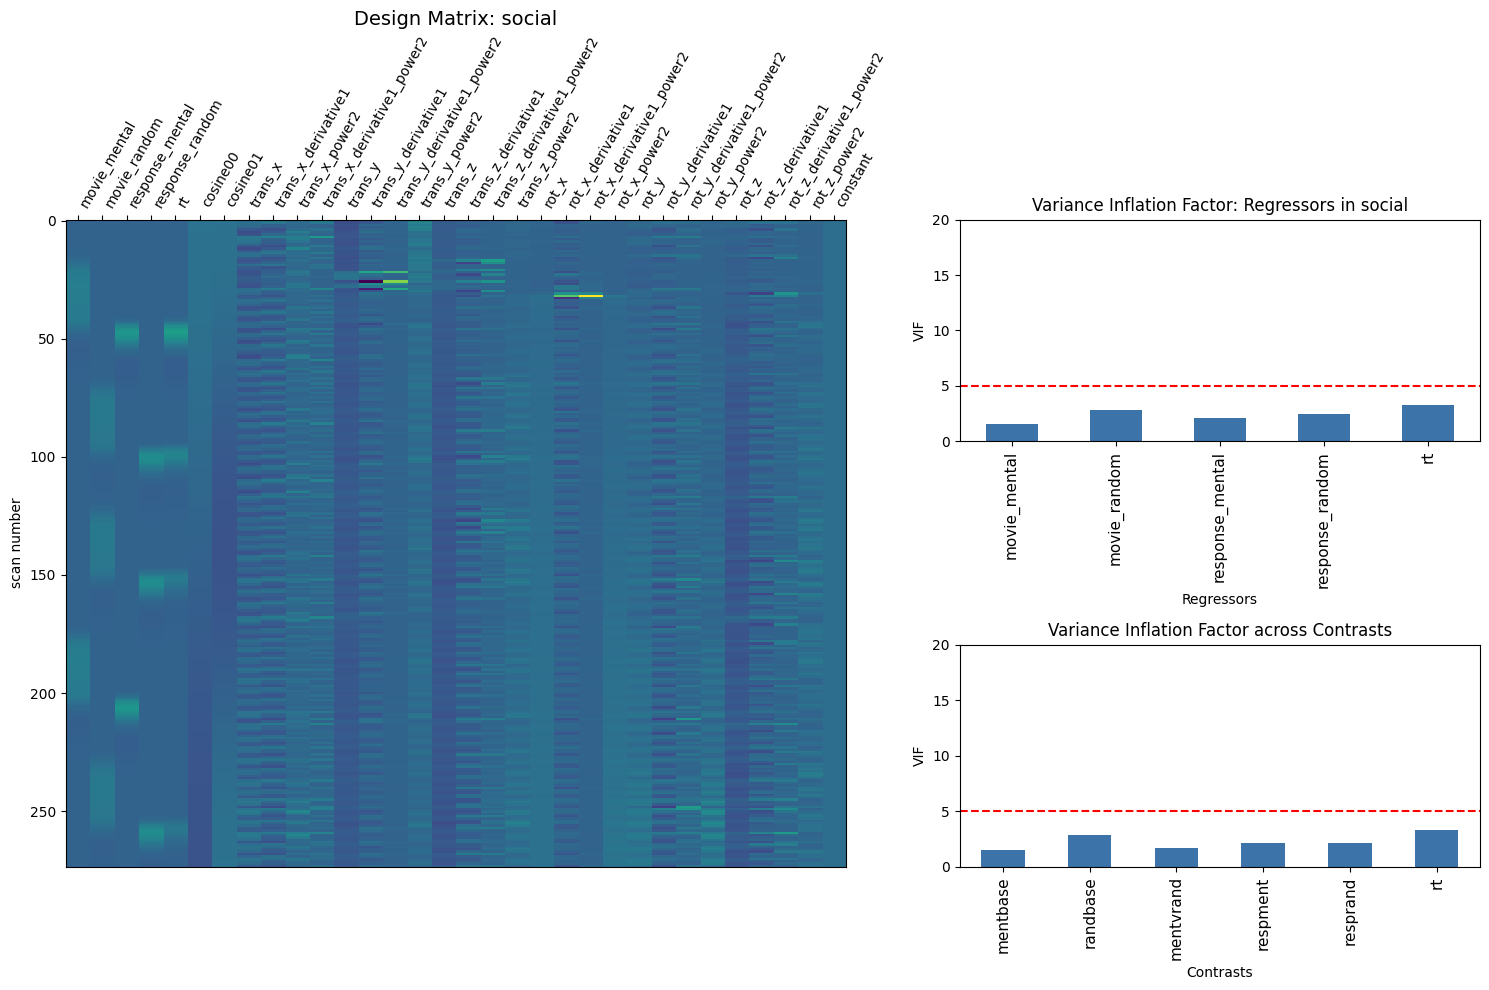

In [23]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_social_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [24]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast mentbase with weight movie_mental
        Successfully saved contrast mentbase
    Working on contrast randbase with weight movie_random
        Successfully saved contrast randbase
    Working on contrast mentvrand with weight movie_mental - movie_random
        Successfully saved contrast mentvrand
    Working on contrast respment with weight response_mental
        Successfully saved contrast respment
    Working on contrast resprand with weight response_mental
        Successfully saved contrast resprand
    Working on contrast rt with weight rt
        Successfully saved contrast rt


# Language

Barch et al. (2013, pg 181). "Two predictors were included in the Language Processing model — Math and Story. The Story predictor covered the variable duration of a short story, question, and response period (~30 s). The Math predictor covered the duration of a set of math questions designed to roughly match the duration of the story blocks."

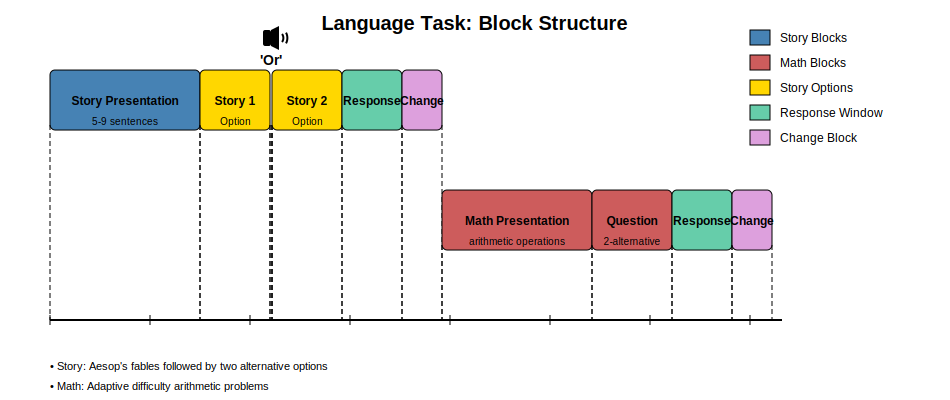

In [25]:
task = "language"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [26]:
config = study_details[task]
ses='ses-3T'
numvols = 316
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['present_story', 'story_to_question', 'full_story',
       'question_story', 'story_opt1', 'story_opt2', 'story_answer',
       'change', 'present_math', 'full_math', 'math_to_question',
       'question_math', 'math_answer'], dtype=object)

The HCP models the entirety of the Story and Math blocks, including the presentation, question, and response/answer window. As reported [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_language), the answer duration windows are relatively similar across math and story blocks (~2900ms). However, the total durations of the full story and math blocks (including presentation, question, and answer) differ significantly: 24,000ms for story and 12,300ms for math. Additionally, the average response time varies between story (3200ms) and math (3900ms), suggesting distinct cognitive processes unfolding across these blocks. These differences should be considered when modeling. The alternative model attempts to account for these task-level differences. Notably, a decision to include/exclude RTs as an individual regressor would result in higher variance inflation factors for the story & and math answer regressors. If the VIFs are exceddingly high, using in contrasts is not recommended.

**Expected Difference in Activation between HCP and Alt Model**: Moderate

### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


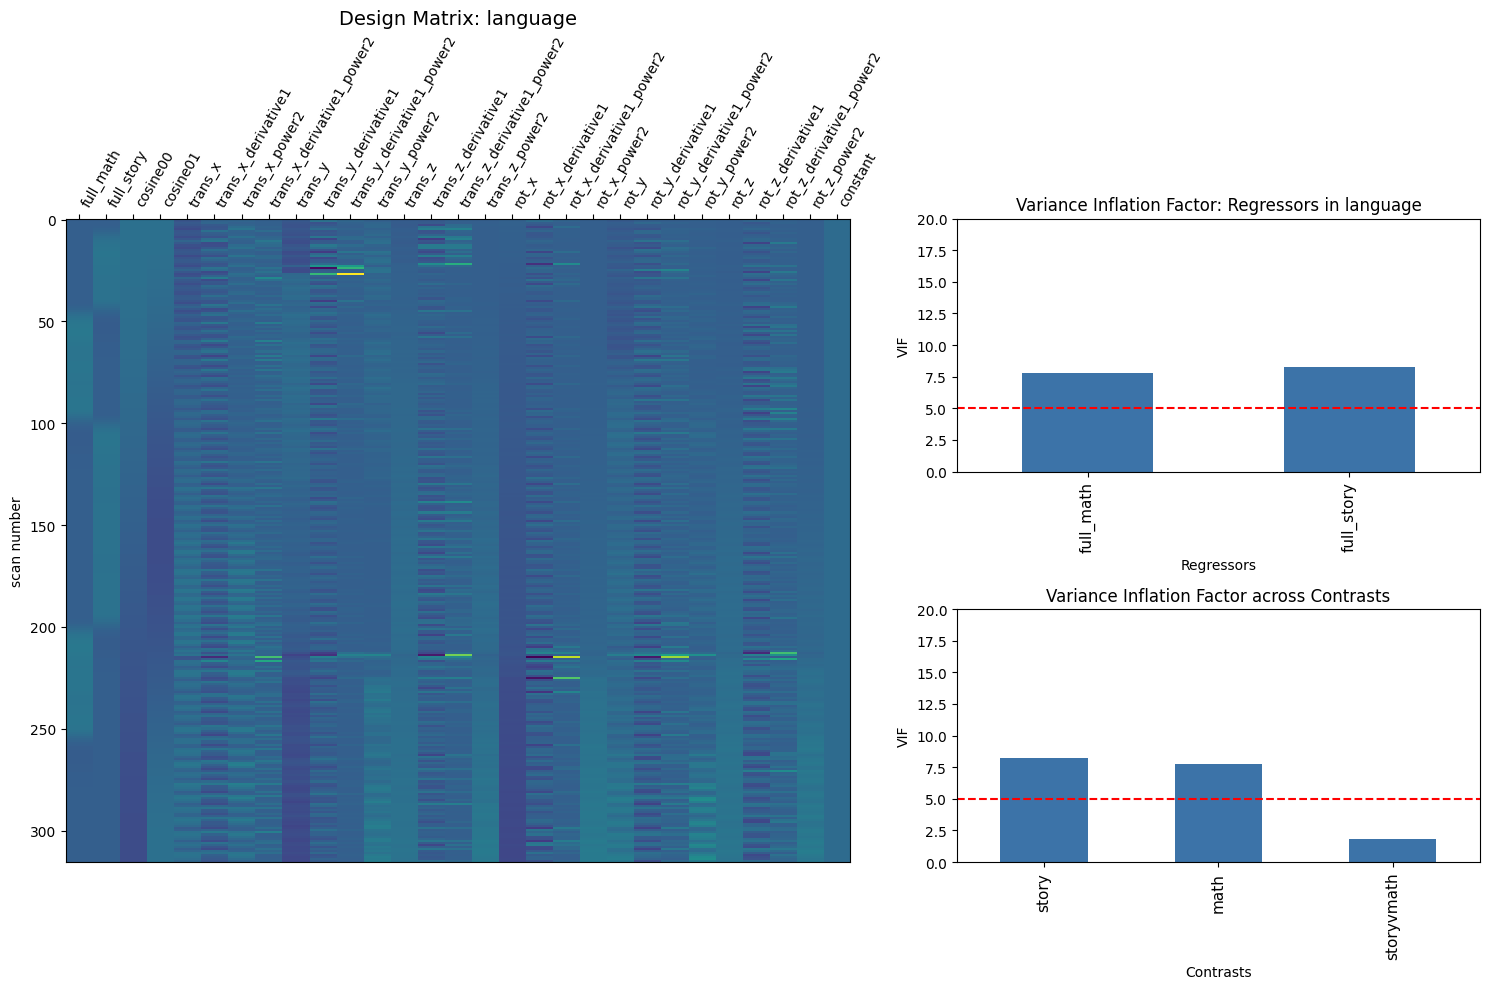

In [27]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_language_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [28]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast story with weight full_story
        Successfully saved contrast story
    Working on contrast math with weight full_math
        Successfully saved contrast math
    Working on contrast storyvmath with weight full_story - full_math
        Successfully saved contrast storyvmath


### Alt Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


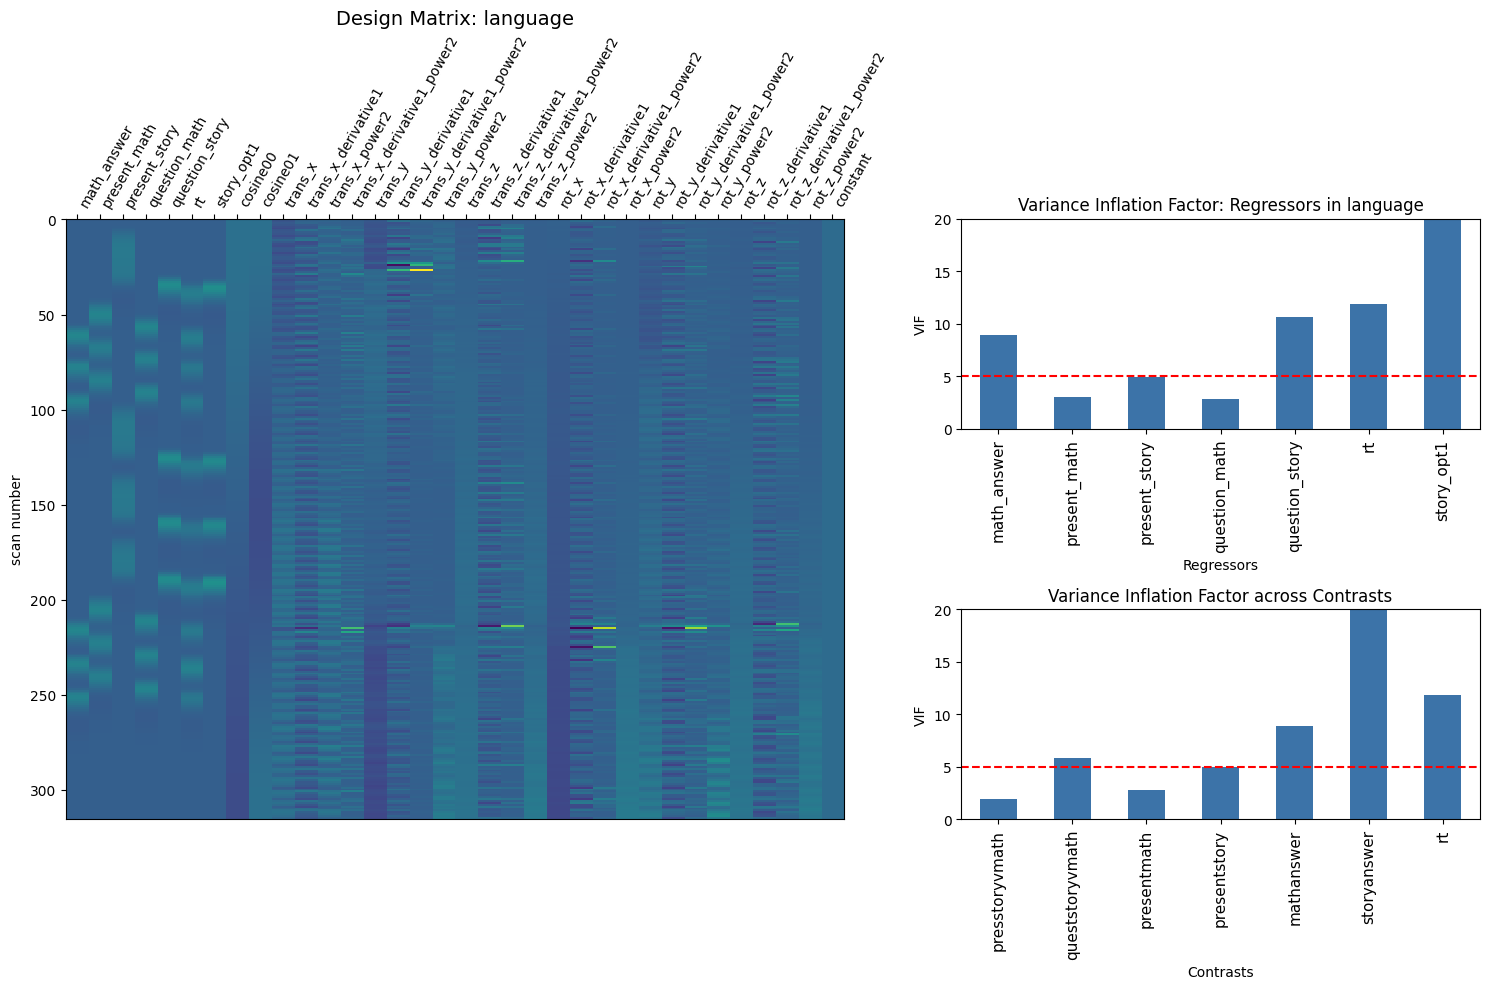

In [29]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_language_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [30]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast presstoryvmath with weight present_story - present_math
        Successfully saved contrast presstoryvmath
    Working on contrast queststoryvmath with weight question_story - question_math
        Successfully saved contrast queststoryvmath
    Working on contrast presentmath with weight question_math
        Successfully saved contrast presentmath
    Working on contrast presentstory with weight present_story
        Successfully saved contrast presentstory
    Working on contrast mathanswer with weight math_answer
        Successfully saved contrast mathanswer
    Working on contrast storyanswer with weight story_opt1
        Successfully saved contrast storyanswer
    Working on contrast rt with weight rt
        Successfully saved contrast rt


# Relational

Barch et al. (2013, pg 181). "Two predictors were included in the Relational Processing model — Relational processing and a control Matching condition. Each predictor covered the duration of 18 s composed of four trials for the Relational condition and five trials for the Matching condition."

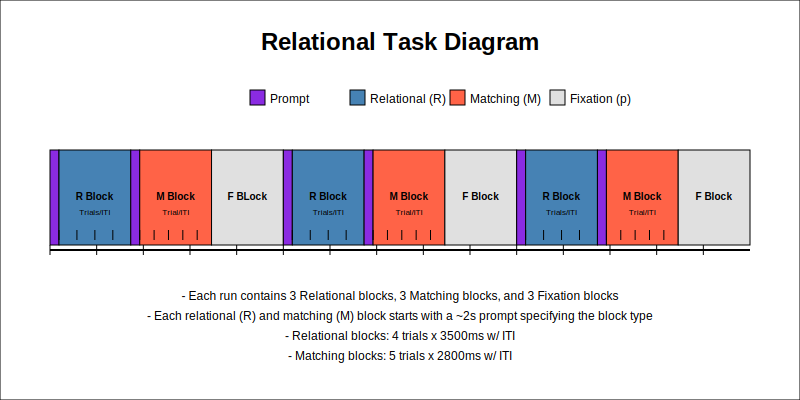

In [31]:
task = "relational"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [32]:
config = study_details[task]
ses='ses-3T'
numvols = 232
boldtr = .720
run = '2'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['relation_prompt', 'relation_stim', 'relation_block',
       'relation_blank', 'control_prompt', 'control_block',
       'control_stim', 'control_blank', 'fix_block'], dtype=object)

The HCP models consecutive trials for the Relational and Control/Matching conditions as complete blocks, disregarding modeling prompts and/or response times. As reported [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_relational), the prompts for the Control and Relational blocks are similar, averaging 1970 ms and 1960 ms, respectively.

While the paper indicates that trial durations for the Control and Relational blocks are 2800 ms and 3500 ms, respectively, timing data from E-Prime suggests some variation, with average durations of 1570 ms for Control and 2130 ms for Relational. Additionally, the ISI durations differ between the Control and Relational blocks, averaging 1670 ms and 1910 ms, respectively. Notably, response times (RTs) vary across stimulus types and blocks.

**Expected Difference in Activation between HCP and Alt Model**: Moderate


### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


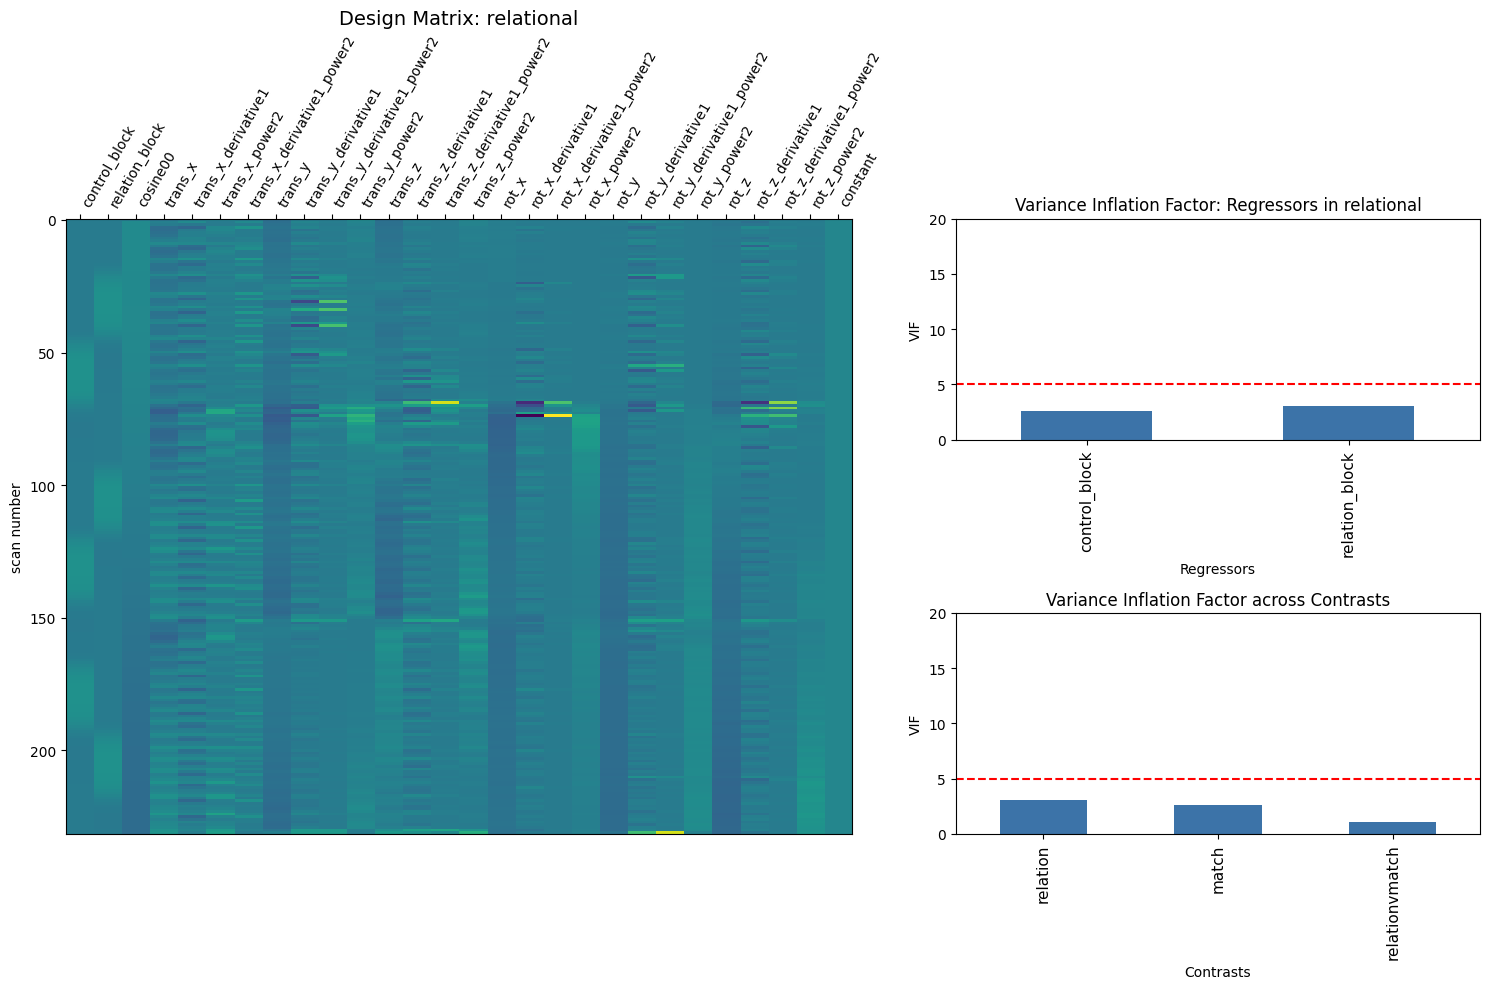

In [33]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_relation_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [34]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast relation with weight relation_block
        Successfully saved contrast relation
    Working on contrast match with weight control_block
        Successfully saved contrast match
    Working on contrast relationvmatch with weight relation_block - control_block
        Successfully saved contrast relationvmatch


### Alt Model

In [35]:
mod_config['trialtype_filter']

['relation_block', 'control_block']

/panfs/jay/groups/2/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/.venv/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
rt.
  warnings.warn(


    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


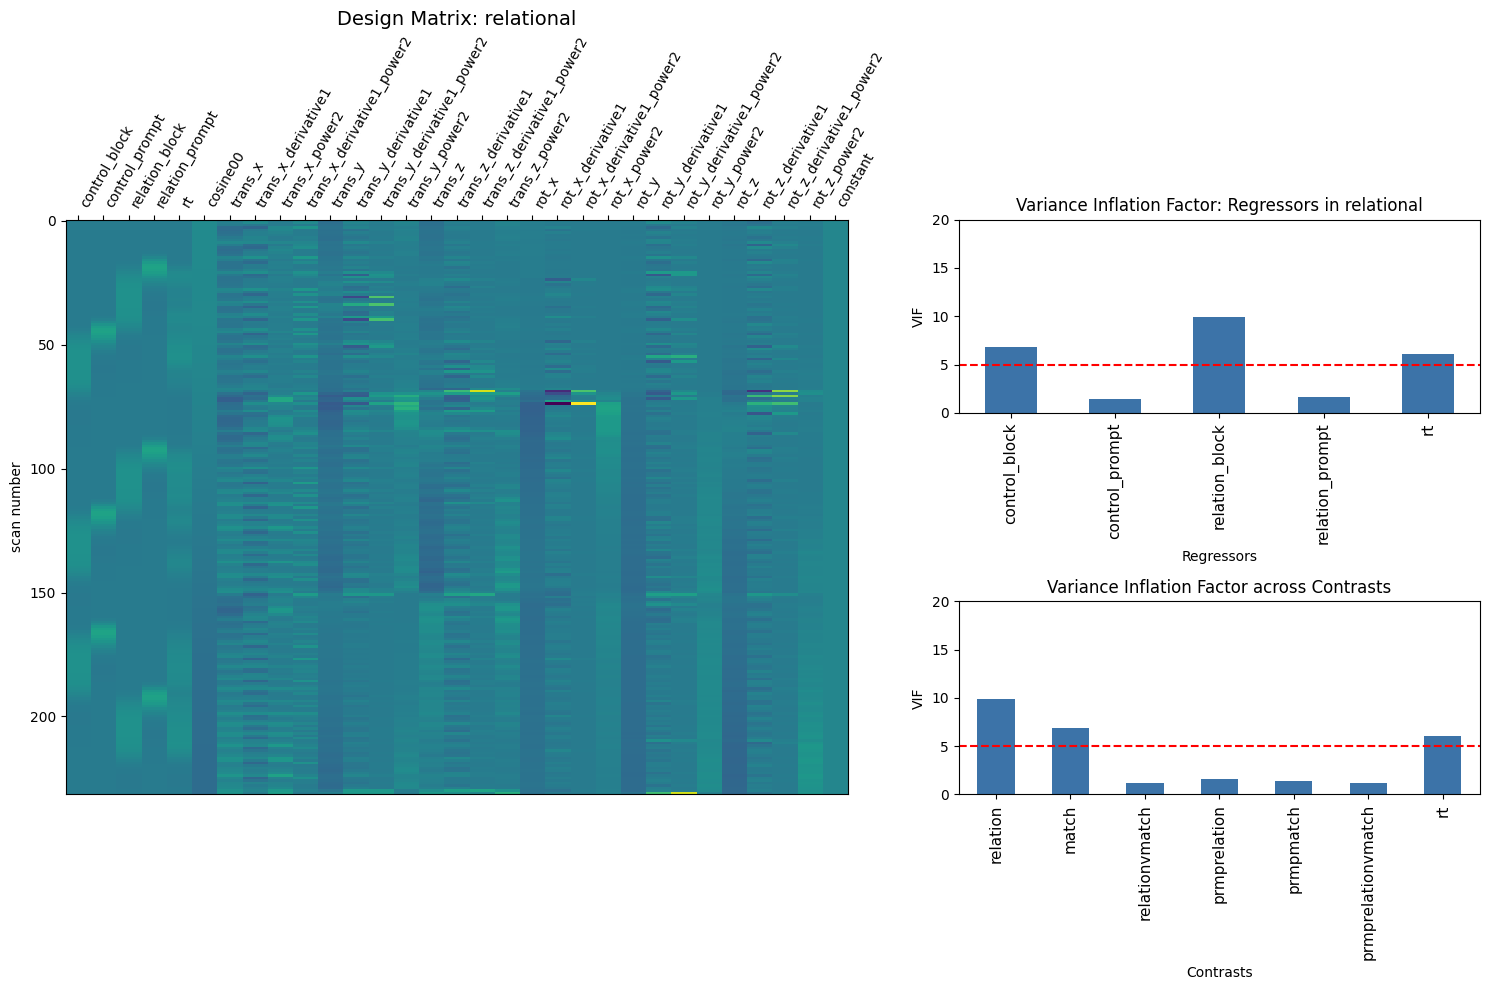

In [36]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_relation_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec)

design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [37]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast relation with weight relation_block
        Successfully saved contrast relation
    Working on contrast match with weight control_block
        Successfully saved contrast match
    Working on contrast relationvmatch with weight relation_block - control_block
        Successfully saved contrast relationvmatch
    Working on contrast prmprelation with weight relation_prompt
        Successfully saved contrast prmprelation
    Working on contrast prmpmatch with weight control_prompt
        Successfully saved contrast prmpmatch
    Working on contrast prmprelationvmatch with weight relation_prompt - control_prompt
        Successfully saved contrast prmprelationvmatch
    Working on contrast rt with weight rt
        Successfully saved contrast rt


# Emotion

Barch et al. (2013, pg 181-182). "Two predictors were included in the Emotion Processing model — Emotional Faces and a Shape control condition. Each predictor covered a 21 s duration composed of a cue and six trials."

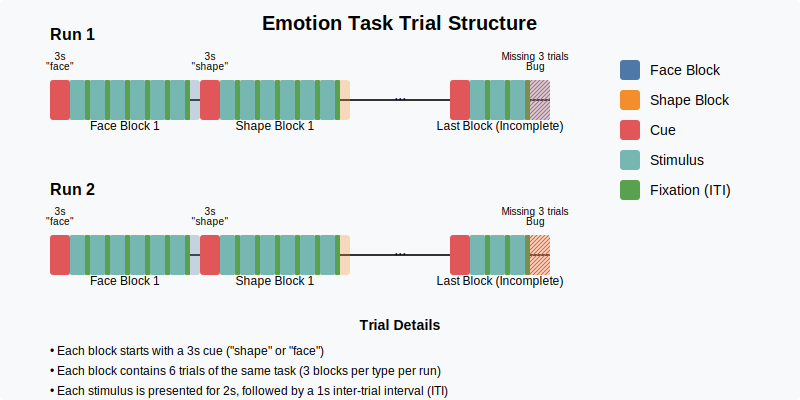

In [38]:
task = "emotion"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Events Design Matrix

In [39]:
config = study_details[task]
ses='ses-3T'
numvols = 176
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['cue_shape', 'shape_block', 'shape_stim', 'shape_isi', 'cue_face',
       'face_stim', 'face_block', 'face_isi'], dtype=object)

### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


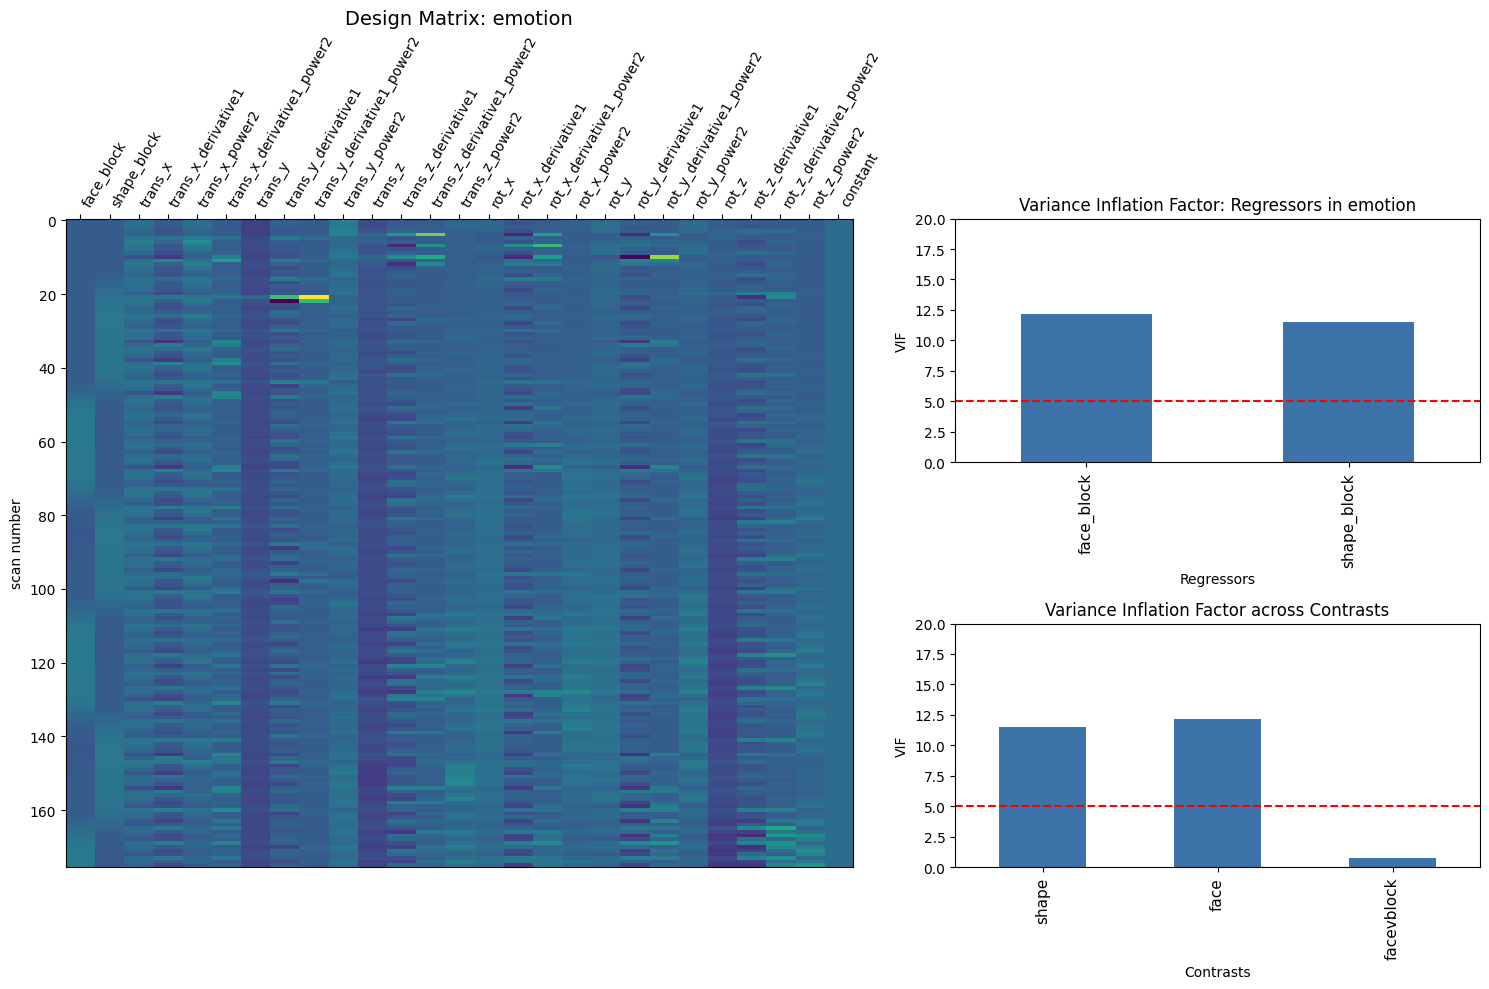

In [40]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_emotion_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [41]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast shape with weight shape_block
        Successfully saved contrast shape
    Working on contrast face with weight face_block
        Successfully saved contrast face
    Working on contrast facevblock with weight shape_block - face_block
        Successfully saved contrast facevblock


### Alt Model

The HCP models the consecutive trials with cue for the faces and shape blocks. As reported [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_emotion), there are some differences in distributions. Consistent with the description of the e-prime coding in the paper, the final block has a duration error but it is unique for the final faces block and not the shapes block. Notably, the timings are impact more by block rather than trial type. In this alternate design, we model cues for each block type and the each block type separately. 

**Expected Difference in Activation between HCP and Alt Model**: Minimal


    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


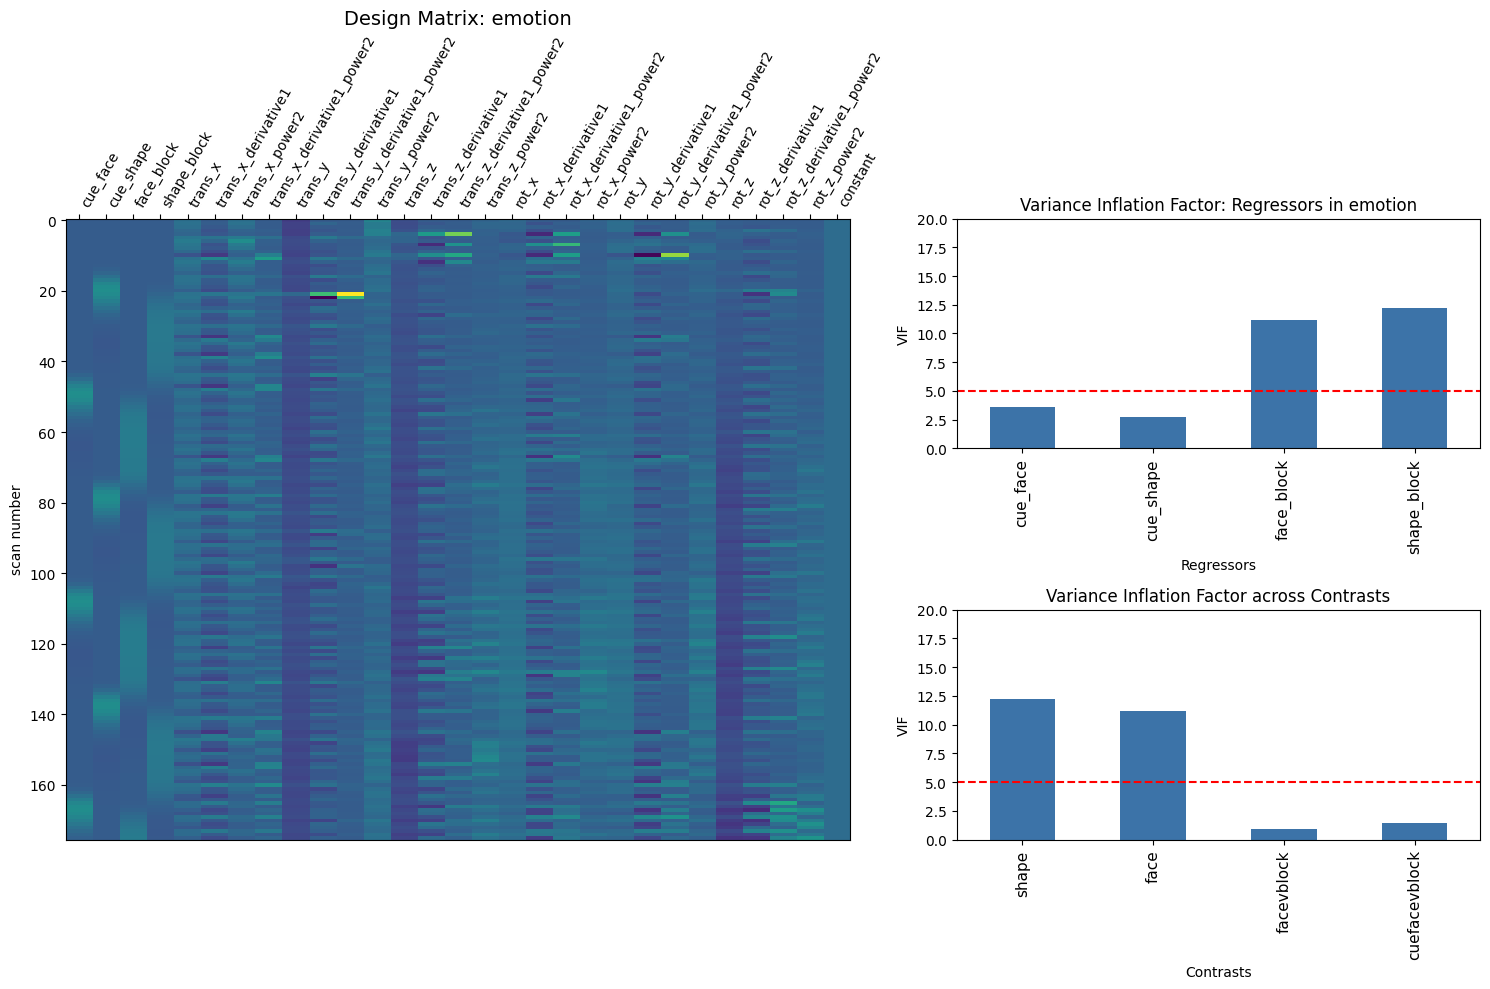

In [42]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_emotion_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [43]:
# bold file
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast shape with weight shape_block
        Successfully saved contrast shape
    Working on contrast face with weight face_block
        Successfully saved contrast face
    Working on contrast facevblock with weight shape_block - face_block
        Successfully saved contrast facevblock
    Working on contrast cuefacevblock with weight cue_face - cue_shape
        Successfully saved contrast cuefacevblock


# Working Memory

Barch et al. (2013, pg 181).  "For both analysis streams, eight predictors were included in the model for Working Memory/Category Specific Representations — one for each type of stimulus in each of the N-back conditions (i.e., 2-Back Body, 0-Back Body, 2-Back Face and  0-Back Face). Each predictor covered the period from the onset of the cue to the offset of the final trial (27.5 s). Linear contrasts for these predictors were computed to estimate effects of interest: 2-back (vs. fixation), 0-back, 2-back vs. 0-back, each stimulus type versus baseline (e.g., Body vs. fixation, collapsing across memory load), and each stimulus type versus all others."

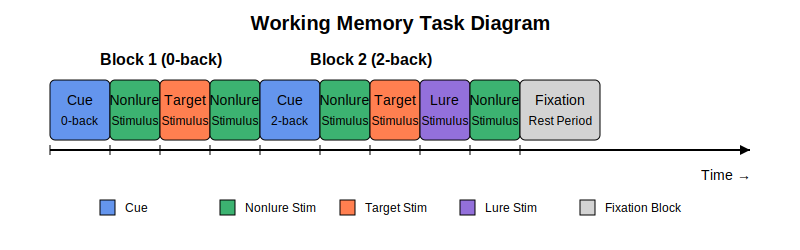

In [44]:
task = "wm" # WM for fmriprep output
task_img = f"{schematic_path}/info_{task}/workmemory_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [45]:
config = study_details[task]
ses='ses-3T'
numvols = 405
boldtr = .720
run = '2'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-wm_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['cue_2back', '2back_nonlure', '2back_full', '2back_lure',
       '2back_target', 'cue_0back', '0back_nonlure', '0back_full',
       '0back_lure', '0back_target', 'fixation'], dtype=object)

The HCP models consecutive trials with cues for the 0-back and 2-back blocks across different trial types (e.g., body, faces, tools). As reported [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_wm), differences in distributions exist. As expected, average response times vary by trial type, with the 2-back conditions being meaningfully slower than the 0-back conditions across non-lure, target, and lure trials. The alternative model takes into account the activation for cue that differ by memory load type (0- and 2-back), the block-level stimuli (0- and 2-back across face, place, tools, body) and the response trial-level response times.

**Expected Difference in Activation between HCP and Alt Model**: Moderate


### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


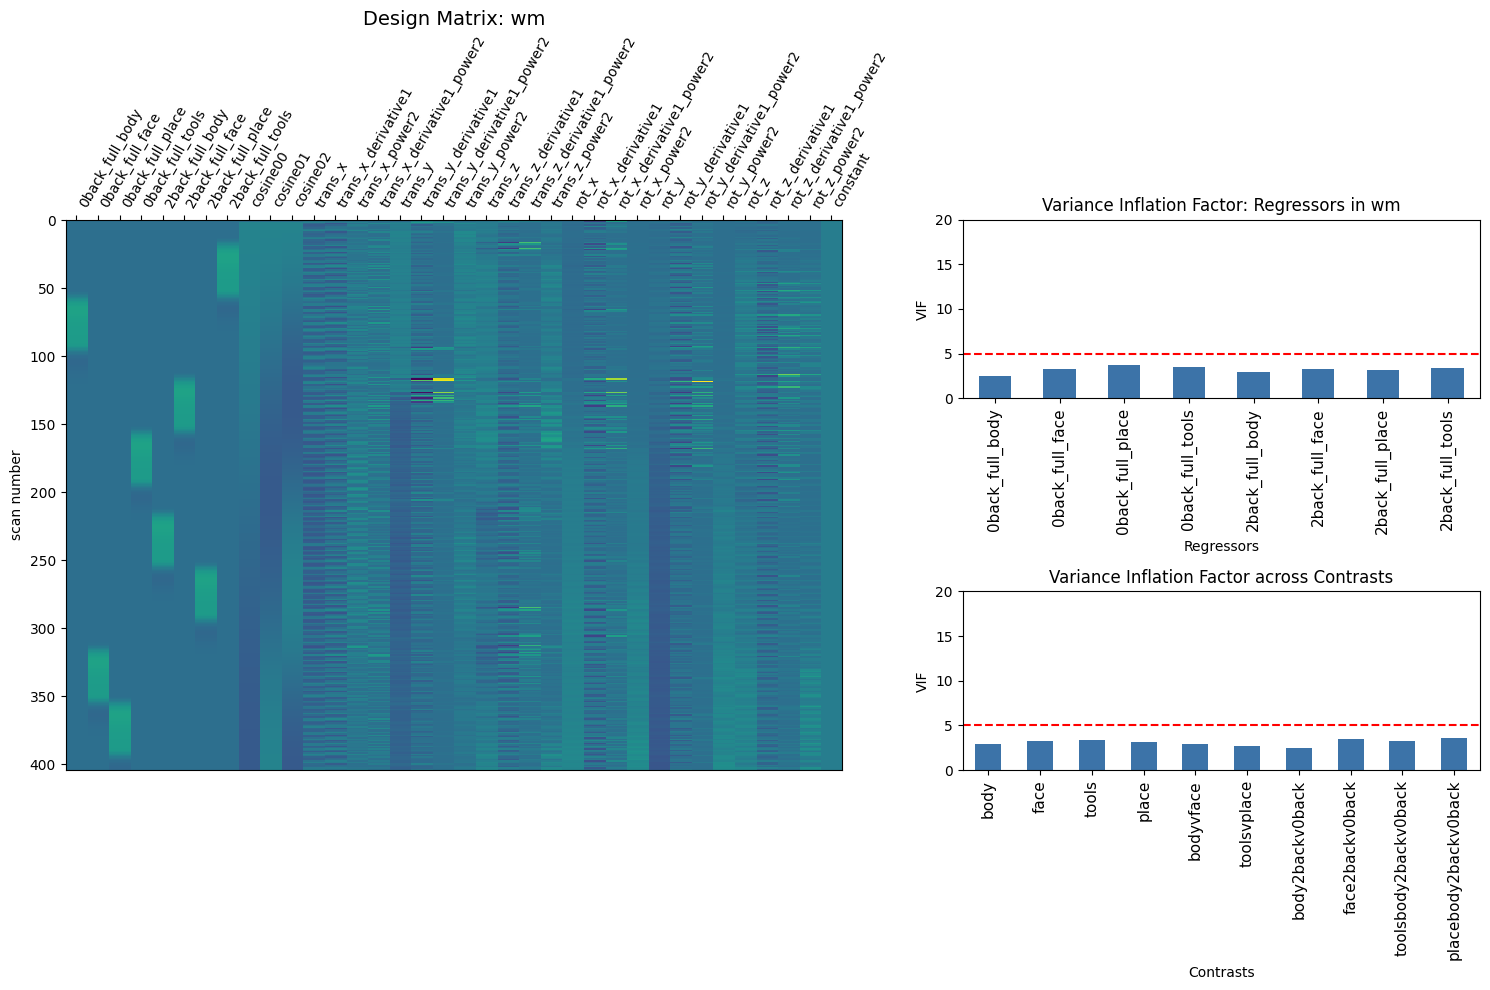

In [46]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files UPDATE MEMORY TO UPPERCASE
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task.upper()}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_wm_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [47]:
# bold file
# task name should be upper for WM
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task.upper()}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast body with weight `2back_full_body`
        Successfully saved contrast body
    Working on contrast face with weight `2back_full_face`
        Successfully saved contrast face
    Working on contrast tools with weight `2back_full_tools`
        Successfully saved contrast tools
    Working on contrast place with weight `2back_full_place`
        Successfully saved contrast place
    Working on contrast bodyvface with weight `2back_full_body` - `2back_full_face`
        Successfully saved contrast bodyvface
    Working on contrast toolsvplace with weight `2back_full_tools` - `2back_full_place`
        Successfully saved contrast toolsvplace
    Working on contrast body2backv0back with weight `2back_full_body` - `0back_full_body`
        Successfully saved contrast body2backv0back
    Working on contrast face2backv0back with weight `2back_full_face` - `0back_full_face`
        Successfully saved contrast face2backv0back
    Working on contrast toolsbody2backv0back

### Alt Model

/panfs/jay/groups/2/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/.venv/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
rt.
  warnings.warn(


    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


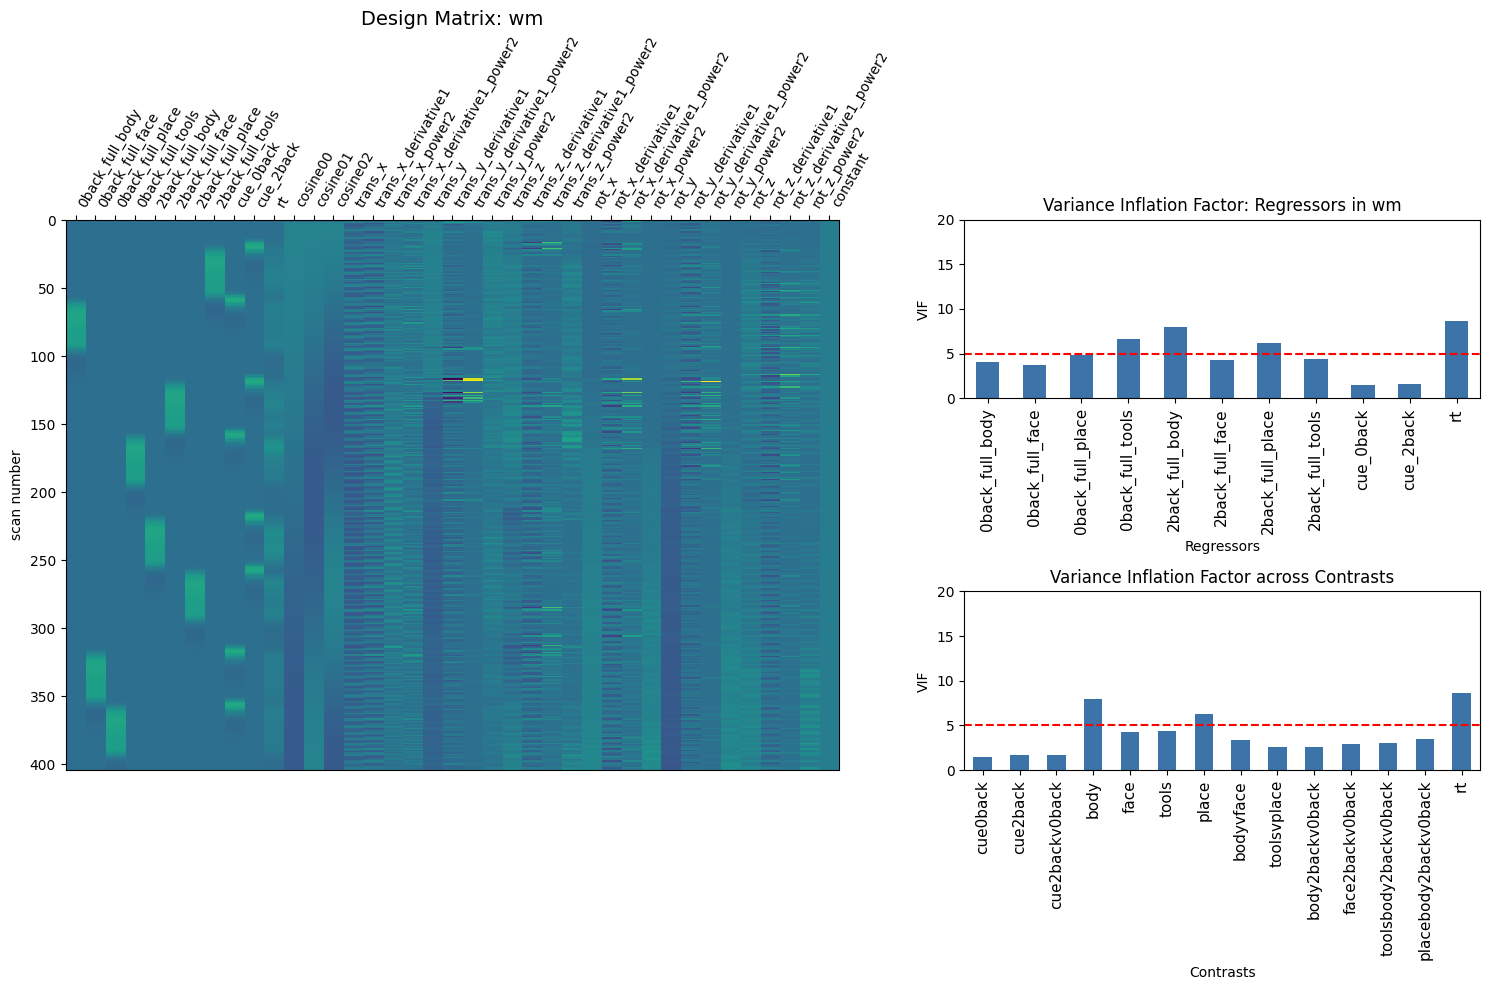

In [48]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files UPDATE MEMORY TO UPPERCASE
conf_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task.upper()}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_wm_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nusiance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
filtered_columns = design_matrix.columns[~design_matrix.columns.str.contains(mod_config['nusiance_regressors'], regex=True)]
reg_dict = {item: item for item in filtered_columns if item != "constant"}
con_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=mod_config['contrasts'])
reg_vifs = est_contrast_vifs(desmat=design_matrix, contrasts=reg_dict)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

#### First Level GLM

In [49]:
# bold file
# task name should be upper for WM
bold_fullpath = f"sub-{subj_id}/ses-3T/func/sub-{subj_id}_ses-3T_task-{task.upper()}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

    Working on contrast cue0back with weight cue_0back
        Successfully saved contrast cue0back
    Working on contrast cue2back with weight cue_2back
        Successfully saved contrast cue2back
    Working on contrast cue2backv0back with weight cue_2back
        Successfully saved contrast cue2backv0back
    Working on contrast body with weight `2back_full_body`
        Successfully saved contrast body
    Working on contrast face with weight `2back_full_face`
        Successfully saved contrast face
    Working on contrast tools with weight `2back_full_tools`
        Successfully saved contrast tools
    Working on contrast place with weight `2back_full_place`
        Successfully saved contrast place
    Working on contrast bodyvface with weight `2back_full_body` - `2back_full_face`
        Successfully saved contrast bodyvface
    Working on contrast toolsvplace with weight `2back_full_tools` - `2back_full_place`
        Successfully saved contrast toolsvplace
    Working on c